

# Dependencies for ISIC2018 final ensemble

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB1
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import random
import cv2

In [2]:
train='D:/CS ML/dataset/ISIC-2017_Training_Data/'
model_path ='D:/CS ML/models/'
data_files = 'D:/CS ML/dataset/ISIC-2017_Training_Data/'

In [3]:
#load metadata 
def load_samples_meta(csv_file):
    data = pd.read_csv(os.path.join(data_files,csv_file))
    data = data[['Image', 'label', 'age_approximate', 'female', 'male', 'StdR', 'StdG', 'StdB', 'Correlation', 'Dissimilarity', 'Homogeneity', 'Energy', 'Contrast']]
    
    
    # Get metadata values into different columns
    Image = list(data.iloc[:,0])
    label = list(data.iloc[:,1])
    age_approximate = list(data.iloc[:,2])
    female = list(data.iloc[:,3])
    male = list(data.iloc[:,4])
    StdR = list(data.iloc[:,5])
    StdG = list(data.iloc[:,6])
    StdB = list(data.iloc[:,7])
    Correlation = list(data.iloc[:,8])
    Dissimilarity = list(data.iloc[:,9])
    Homogeneity = list(data.iloc[:,10])
    Energy = list(data.iloc[:,11])
    Contrast = list(data.iloc[:,12])

    # Get the labels present in the 18th column 
    samples=[]
    for sample, a, b, c, d, e, f, g, h, i, j, k, lab in zip(Image, age_approximate, female, male, StdR, StdG, StdB, Correlation, Dissimilarity, Homogeneity, Energy, Contrast, label):
        samples.append([sample, a, b, c, d, e, f, g, h, i, j, k, lab])
    return samples

In [4]:
#define custom generator for the MISO model that uses only metadata and image data
def generator_meta(samples, batch_size=32,shuffle_data=True,resize=224):
    """
    Yields the next training batch.
    """
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        random.shuffle(samples)

        # Get index to start each batch: [0, batch_size, 2*batch_size, ..., max multiple of batch_size <= num_samples]
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples = samples[offset:offset+batch_size]

            # Initialise X_train and y_train arrays for this batch
            X_train = []
            X_metadata = []
            y_train = []

            # For each example
            for batch_sample in batch_samples:
                # Load image (X) and label (y)
                img_name = batch_sample[0] + '.jpg'
                metadata = batch_sample[1:11]
                label = batch_sample[12]
                img =  cv2.imread(os.path.join(data_files, img_name))
                
                # apply any kind of preprocessing
                img = cv2.resize(img,(224,224))
                # Add example to arrays
                X_train.append(img)
                X_metadata.append(metadata)
                y_train.append(label)

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            X_metadata = np.array(X_metadata)
            
            # y_train = np.array(y_train)
            # true.append(y_train)
            # Convert labels to categorical values
            y_train = np.eye(3)[y_train]

            # The generator-y part: yield the next training batch            
            yield [X_train, X_metadata], y_train

In [5]:
def test_generator_meta(samples, batch_size=1,shuffle_data=False,resize=224):
    """
    Yields the testing batch.
    """
    num_samples = len(samples)
    true = []

    while True: # Loop forever so the generator never terminates

        # Get index to start each batch: [0, batch_size, 2*batch_size, ..., max multiple of batch_size <= num_samples]
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples = samples[offset:offset+batch_size]
            
            # Initialise X_test and y_test arrays for this batch
            X_test = []
            X_metadata = []
            y_test = []
    
            # For each example
            for batch_sample in batch_samples:
                # Load image (X) and label (y)
                img_name = batch_sample[0] + '.jpg'
                metadata = batch_sample[1:11]
                label = batch_sample[12]
                img =  cv2.imread(os.path.join(data_files, img_name))
                
                # apply any kind of preprocessing
                img = cv2.resize(img,(224,224))
                # Add example to arrays
                X_test.append(img)
                X_metadata.append(metadata)
                y_test.append(label)
                
        
            # Make sure they're numpy arrays (as opposed to lists)
            X_test = np.array(X_test)
            X_metadata = np.array(X_metadata)
            # print(y_test)  #for capturing true labels

            #for capturing true labels
            true.append(y_test)  
            # Convert labels to categorical values
            y_test = np.eye(3)[y_test]
            
            
            # The generator-y part: yield the next training batch            
            yield [X_test, X_metadata], y_test

In [6]:
#load metadata and handcrafted features
def load_samples_meta_hfeat(csv_file):
    data = pd.read_csv(os.path.join(data_files,csv_file))
    data = data[['Image', 'age', 'female', 'male', 'StdR', 'StdG', 'StdB', 'Correlation', 'Dissimilarity', 'Homogeneity', 'Energy', 'Contrast', 'Label']]
    # Get image paths locations from the file
    file_names = list(data.iloc[:,0])
    
    # Get metadata values into different columns
    Image = list(data.iloc[:,1])
    label = list(data.iloc[:,2])
    age_approximate = list(data.iloc[:,3])
    female = list(data.iloc[:,4])
    male = list(data.iloc[:,5])
    StdR = list(data.iloc[:,6])
    StdG = list(data.iloc[:,7])
    StdB = list(data.iloc[:,8])
    Correlation = list(data.iloc[:,9])
    Dissimilarity = list(data.iloc[:,10])
    Homogeneity = list(data.iloc[:,11])
    Energy = list(data.iloc[:,12])
    Contrast = list(data.iloc[:,13])

    # Get the labels present in the 18th column 
    samples=[]
    for sample, a, b, c, d, e, f, g, h, i, j, k, l, lab in zip(file_names, Image, age_approximate, female, male, StdR, StdG, StdB, Correlation, Dissimilarity, Homogeneity, Energy, Contrast, label):
        samples.append([sample, a, b, c, d, e, f, g, h, i, j, k, l, lab])
    return samples

In [7]:
def generator_meta_hfeat(samples, batch_size=32,shuffle_data=True,resize=224):
    """
    Yields the next training batch.
    """
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        random.shuffle(samples)

        # Get index to start each batch: [0, batch_size, 2*batch_size, ..., max multiple of batch_size <= num_samples]
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples = samples[offset:offset+batch_size]

            # Initialise X_train and y_train arrays for this batch
            X_train = []
            X_metadata = []
            y_train = []

            # For each example
            for batch_sample in batch_samples:
                # Load image (X) and label (y)
                img_name = batch_sample[0] + '.jpg'
                metadata = batch_sample[1:11]
                label = batch_sample[12]
                img =  cv2.imread(os.path.join(data_files, img_name))
                
                # apply any kind of preprocessing
                img = cv2.resize(img,(224,224))
                # Add example to arrays
                X_train.append(img)
                X_metadata.append(metadata)
                y_train.append(label)

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            X_metadata = np.array(X_metadata)
            
            # y_train = np.array(y_train)
            # true.append(y_train)
            # Convert labels to categorical values
            y_train = np.eye(3)[y_train]

            # The generator-y part: yield the next training batch            
            yield [X_train, X_metadata], y_train

In [8]:
def test_generator_meta_hfeat(samples, batch_size=1,shuffle_data=False,resize=224):
    """
    Yields the testing batch.
    """
    num_samples = len(samples)
    true = []

    while True: # Loop forever so the generator never terminates

        # Get index to start each batch: [0, batch_size, 2*batch_size, ..., max multiple of batch_size <= num_samples]
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples = samples[offset:offset+batch_size]
            
            # Initialise X_test and y_test arrays for this batch
            X_test = []
            X_metadata = []
            y_test = []
    
            # For each example
            for batch_sample in batch_samples:
                # Load image (X) and label (y)
                img_name = batch_sample[0] + '.jpg'
                metadata = batch_sample[1:11]
                label = batch_sample[12]
                img =  cv2.imread(os.path.join(data_files, img_name))
                
                # apply any kind of preprocessing
                img = cv2.resize(img,(224,224))
                # Add example to arrays
                X_test.append(img)
                X_metadata.append(metadata)
                y_test.append(label)
                
        
            # Make sure they're numpy arrays (as opposed to lists)
            X_test = np.array(X_test)
            X_metadata = np.array(X_metadata)
            # print(y_test)  #for capturing true labels

            #for capturing true labels
            true.append(y_test)  
            # Convert labels to categorical values
            y_test = np.eye(3)[y_test]
            
            
            # The generator-y part: yield the next training batch            
            yield [X_test, X_metadata], y_test

In [9]:
from sklearn.metrics import roc_curve
def plot_roc_curve(true, preds, model_name):
    # roc curve for classes
    fpr = {}
    tpr = {}
    thresh ={}
    for i in range(7):    
        fpr[i], tpr[i], thresh[i] = roc_curve(true, preds, pos_label=i)
    
    # plotting  
    plt.figure(figsize=(8, 8))  
    plt.plot(fpr[0], tpr[0], linestyle='--',color='red', label='nothing')
    plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='melanoma')
    plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='seborrheic_keratosis')

    plt.plot([0, 1.0], linestyle='--',color='gray')
    plt.title(f'ROC curve- {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    #plt.savefig('Multiclass ROC',dpi=300);   

In [10]:
#Evaluation metrics
def showconfusionmatrix(cm, model_name):
    pl.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, cmap="rocket", xticklabels=label_map, yticklabels=label_map)
    pl.title('CM- ' + model_name)

def showmetrics(true, pred, model_name):
    accuracy = accuracy_score(true, pred)
    p, r, f, s = precision_recall_fscore_support(true, pred, average = 'weighted')
    cm = confusion_matrix(true, pred)
    TP = np.diag(cm)
    FP = cm.sum(axis=0) - TP  
    FN = cm.sum(axis=1) - TP
    TN = [np.sum(cm), np.sum(cm), np.sum(cm)]

    print(TN)
    print(TP)
    print(FP)
    print(FN)

    TN = TN - (TP + FP + FN)
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    TPR = np.average(TPR, axis=0)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    TNR = np.average(TNR, axis=0)

    print (cm)   
    print ("    ----Model----  ", model_name)
    print ("Accuracy         = ", accuracy)
    print ("Precision        = ", p)
    print ("Recall           = ", r)
    print ("F1_score         = ", f)
    print ("TP               = ", TP)
    print ("FP               = ", FP)
    print ("FN               = ", FN)
    print ("TN               = ", TN)
    print ("Mean Sensitivity = ", TPR)
    print ("Mean Specificity = ", TNR)
    
    cm = confusion_matrix(true, pred, normalize='true')

    showconfusionmatrix(cm, model_name) 

# EfficientNetB4

In [16]:
# this will create a generator object
samples = load_samples_meta("D:\CS ML\Data files\ISIC2017_train_metadata_all.csv")
num_train_samples = len(samples)
#Compute class weights to perform balanced training while having a highly imbalanced dataset
samp = np.array(samples)
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(samp[:,12]), y = samp[:,12])
class_weights = {i : class_weights[i] for i in range(3)}
print('class_weights = ', class_weights)
train_datagen = generator_meta(samples,batch_size=32,shuffle_data=True)

samples = load_samples_meta("D:\CS ML\Data files\ISIC2017_val_metadata_all.csv")
num_val_samples = len(samples)
val_datagen = generator_meta(samples,batch_size=32,shuffle_data=True)

true = [] #This np array is for storing the true labels generated from test_generator
samples = load_samples_meta("D:\CS ML\Data files\ISIC2017_test_metadata_all.csv")
num_test_samples = len(samples)
test_datagen = test_generator_meta(samples,batch_size=1,shuffle_data=False)

class_weights =  {0: 0.4859086491739553, 1: 1.7825311942959001, 2: 2.6246719160104988}


In [13]:
# Build model
def effnet_model():
    img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
    )
    
    inputs = layers.Input(shape=(224, 224, 3))
    x = img_augmentation(inputs)
    model = tf.keras.applications.EfficientNetB4(include_top=False, input_tensor=x, weights="imagenet")
    
    # Freeze the pretrained weights
    model.trainable = False
            
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)
    top_dropout_rate = 0.4
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    x = layers.Flatten()(x)
    model=Model(inputs = inputs, outputs = x)
    return model

def mlp_model(dim):
    inputs = layers.Input(dim)
    x = layers.Dense(256, input_dim=dim, activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    top_dropout_rate = 0.25
    x = layers.Dropout(top_dropout_rate, name="top_dropout_met")(x)
    
    x = layers.Dense(256, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    # x = layers.Dropout(top_dropout_rate, name="top_dropout1")(x)
    
    model=Model(inputs = inputs, outputs = x)
    return model

def concatenated_model(cnn, mlp):
    combinedInput = layers.concatenate([cnn.output, mlp.output])
    x = layers.Dense(1024, activation="relu")(combinedInput)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout_model")(x)
    
    x = layers.Dense(3 , activation="softmax", name="pred")(x)
    model = Model(inputs=[cnn.input, mlp.input], outputs=x)
    return model

cnn = effnet_model()
mlp = mlp_model(10)
model = concatenated_model(cnn, mlp)

# Compile
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'])

Epoch 1/10
62/62 [==============================] - 259s 4s/step - loss: 1.3958 - precision_12: 0.5506 - recall_12: 0.5212 - accuracy: 0.5413 - val_loss: 1.0186 - val_precision_12: 0.6094 - val_recall_12: 0.3047 - val_accuracy: 0.4922 - lr: 0.0010
Epoch 2/10
62/62 [==============================] - 223s 4s/step - loss: 0.9767 - precision_12: 0.6254 - recall_12: 0.6032 - accuracy: 0.6204 - val_loss: 1.0176 - val_precision_12: 0.5323 - val_recall_12: 0.2578 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 3/10
62/62 [==============================] - 220s 4s/step - loss: 0.8549 - precision_12: 0.6443 - recall_12: 0.6103 - accuracy: 0.6316 - val_loss: 1.0121 - val_precision_12: 0.5500 - val_recall_12: 0.3438 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 4/10
62/62 [==============================] - 212s 3s/step - loss: 0.8143 - precision_12: 0.6747 - recall_12: 0.6240 - accuracy: 0.6560 - val_loss: 0.9379 - val_precision_12: 0.6279 - val_recall_12: 0.4219 - val_accuracy: 0.5312 - lr: 0.0010
Epoch 5/

INFO:tensorflow:Assets written to: D:/CS ML/models/efb\assets


Epoch 10/40
62/62 [==============================] - 430s 7s/step - loss: 0.6594 - precision_13: 0.6923 - recall_13: 0.6480 - accuracy: 0.6765 - val_loss: 0.9277 - val_precision_13: 0.6957 - val_recall_13: 0.6400 - val_accuracy: 0.6667 - lr: 1.0000e-04
Epoch 11/40
62/62 [==============================] - 372s 6s/step - loss: 0.5547 - precision_13: 0.7323 - recall_13: 0.6975 - accuracy: 0.7210 - val_loss: 1.0702 - val_precision_13: 0.6573 - val_recall_13: 0.6267 - val_accuracy: 0.6400 - lr: 1.0000e-04
Epoch 12/40
62/62 [==============================] - 375s 6s/step - loss: 0.4867 - precision_13: 0.7774 - recall_13: 0.7455 - accuracy: 0.7620 - val_loss: 0.8838 - val_precision_13: 0.5816 - val_recall_13: 0.5467 - val_accuracy: 0.5867 - lr: 1.0000e-04
Epoch 13/40
62/62 [==============================] - 380s 6s/step - loss: 0.4562 - precision_13: 0.7903 - recall_13: 0.7555 - accuracy: 0.7735 - val_loss: 0.7451 - val_precision_13: 0.7153 - val_recall_13: 0.6867 - val_accuracy: 0.7067 - lr:

INFO:tensorflow:Assets written to: D:/CS ML/models/modelefnet4_meta\assets


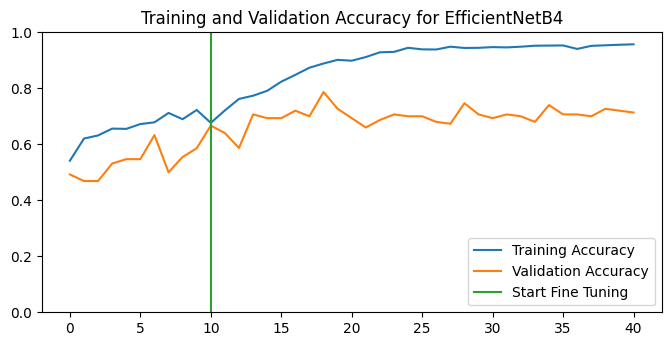

In [210]:
def plot_acc(acc, val_acc, model_name):
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.ylim([0, 1])
  plt.plot([initial_epochs,initial_epochs],
            plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title(f'Training and Validation Accuracy for {model_name}')


initial_epochs = 10
num_train_samples = 2000
num_val_samples = 150
batch_size = 32

history= model.fit(train_datagen, steps_per_epoch = num_train_samples // batch_size, epochs=initial_epochs, validation_data=val_datagen, validation_steps=num_val_samples // batch_size, class_weight = class_weights, callbacks=[ ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=0.00001)])
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

model.save(model_path+'efb')

# unfreeze model and finetune
for layer in model.layers[-490:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'])


#fine tune the unfreezed network
fine_tune_epochs = 30 
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(train_datagen, steps_per_epoch = num_train_samples / batch_size, epochs=total_epochs, initial_epoch=history.epoch[-1],   validation_data=val_datagen, validation_steps=num_val_samples / batch_size, class_weight = class_weights, callbacks=[ ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=0.000001)])
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

# save model
model.save(model_path+'modelefnet4_meta')

# plot model accuracies
plot_acc(acc, val_acc, 'EfficientNetB4')

# EfficientNetB5

In [17]:
def plot_acc(acc, val_acc, model_name):
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.ylim([0, 1])
  plt.plot([initial_epochs,initial_epochs],
            plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title(f'Training and Validation Accuracy for {model_name}')


# Build model
def effnet_model():
    img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
    )
    
    inputs = layers.Input(shape=(224, 224, 3))
    x = img_augmentation(inputs)
    model = tf.keras.applications.EfficientNetB5(include_top=False, input_tensor=x, weights="imagenet")
    
    # Freeze the pretrained weights
    model.trainable = False
            
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)
    top_dropout_rate = 0.4
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    x = layers.Flatten()(x)
    model=Model(inputs = inputs, outputs = x)
    return model

cnn = effnet_model()
mlp = mlp_model(10)
model = concatenated_model(cnn, mlp)

# Compile
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'])

Epoch 1/5
62/62 [==============================] - 274s 4s/step - loss: 1.4189 - precision_5: 0.5340 - recall_5: 0.5025 - accuracy: 0.5222 - val_loss: 1.0454 - val_precision_5: 0.6275 - val_recall_5: 0.2500 - val_accuracy: 0.5156 - lr: 0.0010
Epoch 2/5
62/62 [==============================] - 228s 4s/step - loss: 1.0137 - precision_5: 0.6212 - recall_5: 0.5899 - accuracy: 0.6087 - val_loss: 0.9443 - val_precision_5: 0.6129 - val_recall_5: 0.2969 - val_accuracy: 0.4844 - lr: 0.0010
Epoch 3/5
62/62 [==============================] - 233s 4s/step - loss: 0.8801 - precision_5: 0.6395 - recall_5: 0.6032 - accuracy: 0.6199 - val_loss: 1.0085 - val_precision_5: 0.6140 - val_recall_5: 0.2734 - val_accuracy: 0.4531 - lr: 0.0010
Epoch 4/5
62/62 [==============================] - 236s 4s/step - loss: 0.7854 - precision_5: 0.6672 - recall_5: 0.6225 - accuracy: 0.6509 - val_loss: 0.9648 - val_precision_5: 0.6264 - val_recall_5: 0.4453 - val_accuracy: 0.5703 - lr: 0.0010
Epoch 5/5
62/62 [===========

INFO:tensorflow:Assets written to: D:/CS ML/models/efb\assets


Epoch 5/20
62/62 [==============================] - 499s 8s/step - loss: 0.6907 - precision_6: 0.6977 - recall_6: 0.6474 - accuracy: 0.6784 - val_loss: 0.8514 - val_precision_6: 0.6667 - val_recall_6: 0.5156 - val_accuracy: 0.6328 - lr: 1.0000e-04
Epoch 6/20
62/62 [==============================] - 441s 7s/step - loss: 0.6875 - precision_6: 0.6996 - recall_6: 0.6519 - accuracy: 0.6773 - val_loss: 0.8814 - val_precision_6: 0.7130 - val_recall_6: 0.6016 - val_accuracy: 0.6562 - lr: 1.0000e-04
Epoch 7/20
62/62 [==============================] - 443s 7s/step - loss: 0.5335 - precision_6: 0.7543 - recall_6: 0.7099 - accuracy: 0.7322 - val_loss: 0.8979 - val_precision_6: 0.6667 - val_recall_6: 0.6250 - val_accuracy: 0.6641 - lr: 1.0000e-04
Epoch 8/20
62/62 [==============================] - ETA: 0s - loss: 0.5032 - precision_6: 0.7743 - recall_6: 0.7409 - accuracy: 0.7617
Epoch 8: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
62/62 [==============================] - 445s

INFO:tensorflow:Assets written to: D:/CS ML/models/modelefnet5_meta\assets


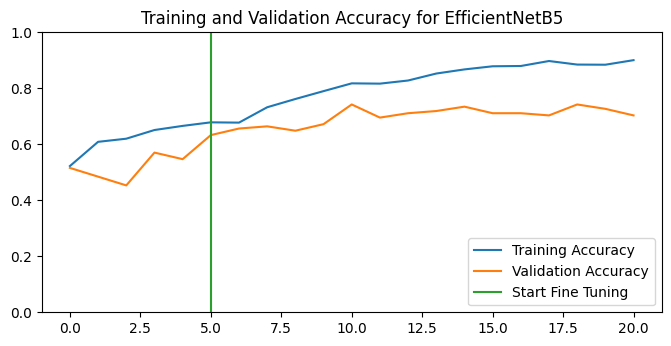

In [18]:
# Compile
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'])


initial_epochs = 5
num_train_samples = 2000
num_val_samples = 150
batch_size = 32
history= model.fit(
        train_datagen,
        steps_per_epoch = num_train_samples // batch_size,
        epochs=initial_epochs,
        validation_data=val_datagen,
        validation_steps=num_val_samples // batch_size,
        class_weight = class_weights,
        callbacks=[ ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=0.00001)])
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

model.save(model_path+'efb')


# unfreeze model and finetune
for layer in model.layers[-590:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'])


#fine tune the unfreezed network
fine_tune_epochs = 15 
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(
        train_datagen,
        steps_per_epoch = num_train_samples // batch_size,
        epochs=total_epochs,
        initial_epoch=history.epoch[-1],
        validation_data=val_datagen,
        validation_steps=num_val_samples // batch_size,
        class_weight = class_weights,
        callbacks=[ ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=0.000001)])
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

# save model
model.save(model_path+'modelefnet5_meta')

# plot model accuracies
plot_acc(acc, val_acc, 'EfficientNetB5')

# EfficientNetB6

In [ ]:
# Build model
def effnet_model():
    img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
    )
    
    inputs = layers.Input(shape=(224, 224, 3))
    x = img_augmentation(inputs)
    model = tf.keras.applications.EfficientNetB6(include_top=False, input_tensor=x, weights="imagenet")
    
    # Freeze the pretrained weights
    model.trainable = False
            
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)
    top_dropout_rate = 0.4
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    x = layers.Flatten()(x)
    model=Model(inputs = inputs, outputs = x)
    return model

cnn = effnet_model()
mlp = mlp_model(10)
model = concatenated_model(cnn, mlp)

# Compile
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'])

In [ ]:
initial_epochs = 5
num_train_samples = 2000
num_val_samples = 150
batch_size = 32
history= model.fit(
        train_datagen,
        steps_per_epoch = num_train_samples // batch_size,
        epochs=initial_epochs,
        validation_data=val_datagen,
        validation_steps=num_val_samples // batch_size,
        class_weight = class_weights,
        callbacks=[ ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=0.00001)])
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

model.save(model_path+'efb')


# unfreeze model and finetune
for layer in model.layers[-680:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'])


#fine tune the unfreezed network
fine_tune_epochs = 30 
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(
        train_datagen,
        steps_per_epoch = num_train_samples // batch_size,
        epochs=total_epochs,
        initial_epoch=history.epoch[-1],
        validation_data=val_datagen,
        validation_steps=num_val_samples // batch_size,
        class_weight = class_weights,
        callbacks=[ ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=0.000001)])
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

# save model
model.save(model_path+'modelefnet6_meta')

# plot model accuracies
plot_acc(acc, val_acc, 'EfficientNetB6')

# EfficientNetB7

In [ ]:
# Build model
def effnet_model():
    img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
    )
    
    inputs = layers.Input(shape=(224, 224, 3))
    x = img_augmentation(inputs)
    model = tf.keras.applications.EfficientNetB7(include_top=False, input_tensor=x, weights="imagenet")
    
    # Freeze the pretrained weights
    model.trainable = False
            
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)
    top_dropout_rate = 0.4
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    x = layers.Flatten()(x)
    model=Model(inputs = inputs, outputs = x)
    return model

cnn = effnet_model()
mlp = mlp_model(10)
model = concatenated_model(cnn, mlp)

# Compile
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'])

In [ ]:
initial_epochs = 5
num_train_samples = 2000
num_val_samples = 150
batch_size = 32

# unfreeze model and finetune
for layer in model.layers[-100:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'])


#fine tune the unfreezed network
fine_tune_epochs = 15 
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(
        train_datagen,
        steps_per_epoch = num_train_samples // batch_size,
        epochs=total_epochs,
        initial_epoch=9,
        validation_data=val_datagen,
        validation_steps=num_val_samples // batch_size,
        class_weight = class_weights,
        callbacks=[ ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=0.000001)])
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

# save model
model.save(model_path+'modelefnet7_meta')

# plot model accuracies
plot_acc(acc, val_acc, 'EfficientNetB7')

# Ensembles of Networks

In [32]:
# Load all models
model0 = tf.keras.models.load_model(model_path+'modelefnet4_meta')
model1 = tf.keras.models.load_model(model_path+'modelefnet5_meta')
model2 = tf.keras.models.load_model(model_path+'modelefnet6_meta')
model3 = tf.keras.models.load_model(model_path+'modelefnet7_meta')


In [33]:
# models = [model0,model1,model2,model3]
models = [model1]

In [34]:
NUM_CLASSES = 3
samples = load_samples_meta("D:\CS ML\Data files\ISIC2017_test_metadata_all.csv")
test_datagen = test_generator_meta(samples,batch_size=1,shuffle_data=False)
prediction0 = model0.predict(test_datagen, batch_size=1, steps=600)

test_datagen = test_generator_meta(samples,batch_size=1,shuffle_data=False)
prediction1 = model1.predict(test_datagen, batch_size=1, steps=600)

test_datagen = test_generator_meta(samples,batch_size=1,shuffle_data=False)
prediction2 = model2.predict(test_datagen, batch_size=1, steps=600)

test_datagen = test_generator_meta(samples,batch_size=1,shuffle_data=False)
prediction3 = model3.predict(test_datagen, batch_size=1, steps=600)


600/600 [==============================] - 167s 274ms/step


In [35]:
true = []
for i in range(len(samples)):
    true.append(samples[i][-1])
print('labels  : ', true)

labels  :  [2, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 1, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 2, 1, 2, 2, 0, 0, 1, 1, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 1, 0, 2, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 1, 0, 1, 1, 1, 2, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 2, 1, 1, 2, 1, 0, 1, 2, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 2, 1, 1, 0, 2, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 0, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: Undefined

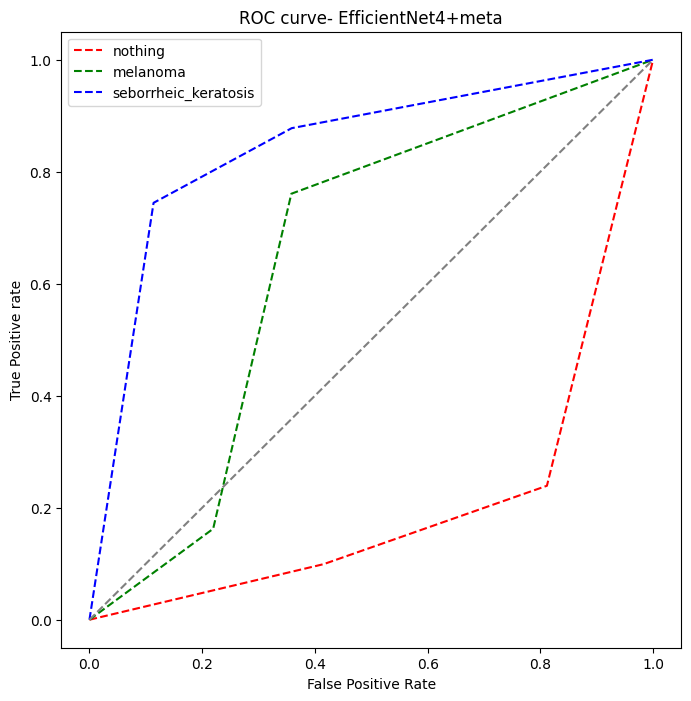

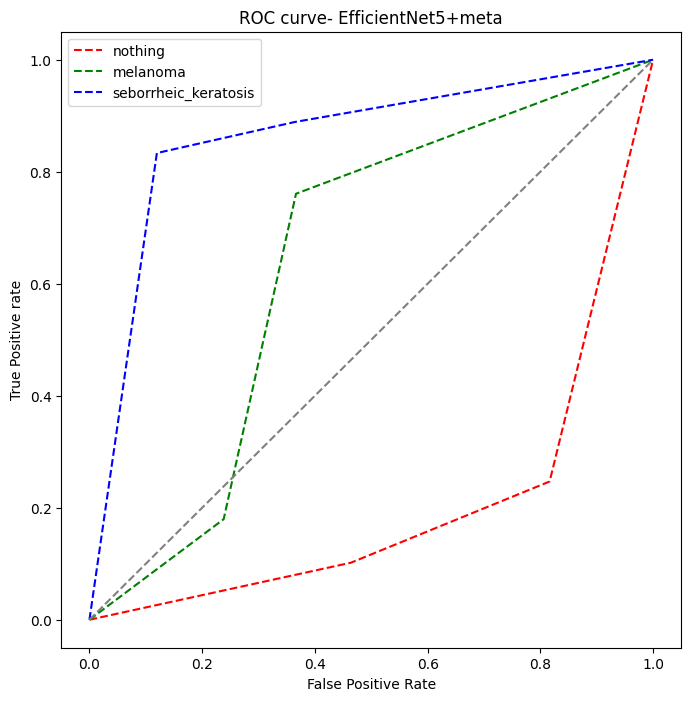

In [36]:
plot_roc_curve(true, prediction0.argmax(axis=-1), 'EfficientNet4+meta')
plot_roc_curve(true, prediction1.argmax(axis=-1), 'EfficientNet5+meta')
plot_roc_curve(true, prediction2.argmax(axis=-1), 'EfficientNet6+meta')
plot_roc_curve(true, prediction3.argmax(axis=-1), 'EfficientNet7+meta')

In [37]:
#print all labels for comparison
label_map= ['nothing','melanoma','seborrheic keratosis']
print('classes', label_map)

# capturing true labels from test data generator
true = np.array(true).flatten()
print('labels  : ', true)

# print predicted labels
pred_labels0 = prediction0.argmax(axis=-1)
print('preds_0 : ', pred_labels0)
pred_labels1 = prediction1.argmax(axis=-1)
print('preds_1 : ', pred_labels1)
pred_labels2 = prediction2.argmax(axis=-1)
print('preds_2 : ', pred_labels2)
pred_labels3 = prediction3.argmax(axis=-1)
print('preds_3 : ', pred_labels3)

classes ['nothing', 'melanoma', 'seborrheic keratosis']
labels  :  [2 0 0 2 2 0 0 0 2 2 2 2 0 2 2 2 1 2 2 2 2 2 2 2 1 0 2 2 1 2 2 2 2 1 2 1 2
 2 2 2 0 0 2 2 2 2 0 0 0 2 0 0 2 1 2 0 0 0 2 2 0 0 2 0 2 0 2 1 2 2 0 0 1 1
 2 0 0 0 2 2 0 0 2 0 0 0 1 0 2 2 1 2 0 2 1 0 1 2 0 1 1 0 1 1 1 2 1 1 0 0 0
 1 1 1 0 0 1 1 1 2 1 1 2 1 0 1 2 1 1 0 0 1 1 1 1 1 0 0 1 0 1 1 1 1 0 2 1 1
 0 2 1 1 1 0 1 1 0 1 1 1 2 1 1 1 1 1 2 1 1 2 1 1 1 1 1 1 2 2 2 2 1 1 1 2 0
 2 1 1 2 2 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 0
 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0
 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [273]:
preds = [prediction0,prediction1,prediction2,prediction0]
preds=np.array(preds)
summed = np.sum(preds, axis=0)
# argmax across classes
ensemble_prediction = np.argmax(summed, axis=-1)
print('preds_en :', ensemble_prediction)

preds_en : [0 0 0 2 2 0 0 0 2 1 1 2 0 2 1 1 1 1 1 2 2 1 2 0 1 1 2 2 0 2 2 2 2 0 2 0 2
 2 2 2 0 0 1 2 0 2 0 0 0 0 0 0 2 0 2 0 0 1 1 2 0 2 2 2 2 2 2 1 2 2 0 0 1 0
 2 0 2 0 2 2 0 2 0 0 0 0 1 0 1 2 1 2 1 0 2 0 1 2 0 2 0 0 0 1 0 2 1 1 1 0 0
 2 1 1 0 1 1 1 1 2 2 1 2 1 0 0 2 0 1 0 1 2 1 1 0 1 0 0 1 2 1 2 1 1 2 2 1 1
 0 2 2 0 1 0 1 0 0 1 1 1 2 1 2 1 0 1 2 0 1 0 0 0 1 1 1 1 0 2 0 1 1 0 2 0 2
 2 1 1 1 2 1 1 1 1 1 1 1 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 0
 1 0 0 2 2 0 1 0 0 2 0 0 1 0 0 0 0 0 0 1 0 1 0 0 2 0 0 2 0 0 0 0 0 0 0 0 0
 1 2 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 1 0 0 0 0 0 0 1 0 0 0 0 0 2
 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 2 0 2 0 0
 2 0 1 0 2 2 1 0 1 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 0 2 0 1 0 0 0 1 1 0
 2 0 0 1 1 1 2 2 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 2 0 0 0 1 0 0 2 0 0 0 0 2 1
 0 1 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 1 2 0 0 0 1 1 0 1 0 0 0 0 1 0 2 0 0 1
 2 0 0 0 0 1 0 1 2 0 0 1 0 0 1 0 0 0 0 2 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 2

[600, 600, 600]
[299  70  67]
[39 67 58]
[94 47 23]
[[299  55  39]
 [ 28  70  19]
 [ 11  12  67]]
    ----Model----   EfficientNetB4_meta
Accuracy         =  0.7266666666666667
Precision        =  0.7594581134194273
Recall           =  0.7266666666666667
F1_score         =  0.7367963204325861
TP               =  [299  70  67]
FP               =  [39 67 58]
FN               =  [94 47 23]
TN               =  [168 416 452]
Mean Sensitivity =  0.7011830973663035
Mean Specificity =  0.853050785531604
[600, 600, 600]
[296  68  75]
[38 62 61]
[97 49 15]
[[296  57  40]
 [ 28  68  21]
 [ 10   5  75]]
    ----Model----   EfficientNetB5_meta
Accuracy         =  0.7316666666666667
Precision        =  0.7651996301514618
Recall           =  0.7316666666666667
F1_score         =  0.7402959569316836
TP               =  [296  68  75]
FP               =  [38 62 61]
FN               =  [97 49 15]
TN               =  [169 421 449]
Mean Sensitivity =  0.7225701920358408
Mean Specificity =  0.85615096280057

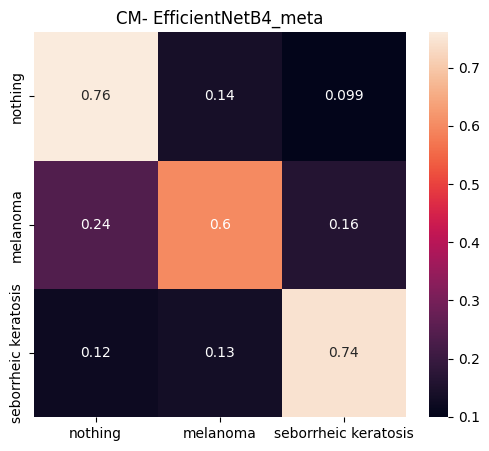

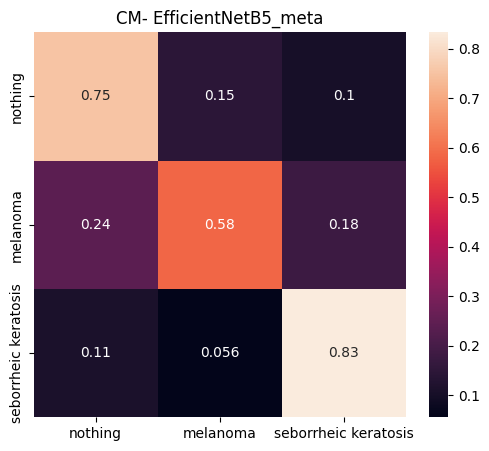

In [38]:
showmetrics(true, pred_labels0, 'EfficientNetB4_meta')
showmetrics(true, pred_labels1, 'EfficientNetB5_meta')
showmetrics(true, pred_labels2, 'EfficientNetB6_meta')
showmetrics(true, pred_labels3, 'EfficientNetB7_meta')

[600, 600, 600]
[299  70  67]
[39 67 58]
[94 47 23]
[[299  55  39]
 [ 28  70  19]
 [ 11  12  67]]
    ----Model----   Ensemble
Accuracy         =  0.7266666666666667
Precision        =  0.7594581134194273
Recall           =  0.7266666666666667
F1_score         =  0.7367963204325861
TP               =  [299  70  67]
FP               =  [39 67 58]
FN               =  [94 47 23]
TN               =  [168 416 452]
Mean Sensitivity =  0.7011830973663035
Mean Specificity =  0.853050785531604


NameError: name 'ens_pred_code' is not defined

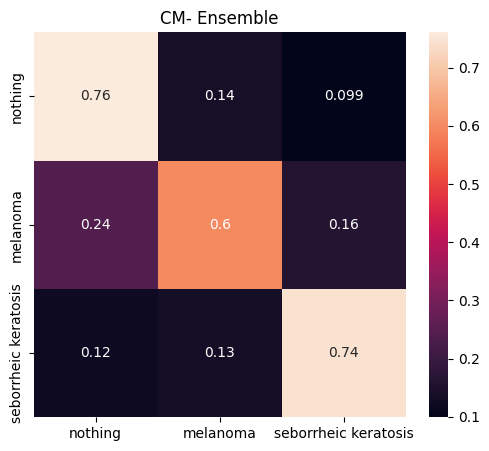

In [280]:
#Evaluation metrics for all efficientnets b0 to b7
showmetrics(true, ensemble_prediction, 'Ensemble')
#to plot ensemble predictions roc plot for each class
plot_roc_curve(true, ens_pred_code, 'Ensemble Model')

# Weighted Ensemble- Accuracy based

In [283]:
# Weighted Ensemble- Grid search for the best combination of weights that gives maximum acuracy

import pandas as pd
df = pd.DataFrame([])
count=0
for w0 in range(0,5):
  for w1 in range(0,5):
    for w2 in range(0,5):
      count=count+1
      print('check', count)
      wts = [w0/10., w1/10., w2/10.]
      #wts = [0, 0, 0, 0, w4/10., w5/10., w6/10., w7/10.]
      print('wts = ',wts)
      wted_preds = np.tensordot(preds, wts, axes=((0),(0)))
      wted_ensemble_pred = np.argmax(wted_preds, axis=1)
      weighted_accuracy = accuracy_score(true, wted_ensemble_pred)
      df = df.append(pd.DataFrame({'wt0':wts[0], 'wt1':wts[1], 'wt2':wts[2], 'acc':weighted_accuracy*100}, index=[0]), ignore_index=True)  

check 1
wts =  [0.0, 0.0, 0.0]


ValueError: shape-mismatch for sum

In [ ]:
#Find the weight combinations giving max accuracy
max_acc_row = df.iloc[df['acc'].idxmax()]
print("Max accuracy of ", max_acc_row[8], " obained with w0=", max_acc_row[0], " w1=", max_acc_row[1], " w2=", max_acc_row[2], 
      " w3=", max_acc_row[3], " w4=", max_acc_row[4], " w5=", max_acc_row[5], " w6=", max_acc_row[6], " w7=", max_acc_row[7])

In [ ]:
# Ideal weighted ensemble model. of rectifies test dataset

ideal_weights = [0.0, 0.4, 0.1, 0.4, 0.0, 0.2, 0.3, 0.3] #89.2750, tpr= 88.537

#Use tensordot to sum the products of all elements over specified axes.
ideal_weighted_preds = np.tensordot(preds, ideal_weights, axes=((0),(0)))
ideal_weighted_ensemble_prediction = np.argmax(ideal_weighted_preds, axis=1)

In [ ]:
showmetrics(true, ideal_weighted_ensemble_prediction, 'Weighted Ensemble- Accuracy based')

In [ ]:
plot_roc_curve(true, ideal_weighted_preds, 'Weighted Ensemble Model- Accuracy based')

# Weighted Ensembles- TPR based

In [ ]:
# Weighted Ensemble- Grid search for the best combination of weights that gives maximum acuracy

import pandas as pd
df = pd.DataFrame([])
count=0
for w0 in range(0,10):
  for w1 in range(0,10):
    for w2 in range(0,10):
      for w3 in range(0,10):
        for w4 in range(0,10):
          for w5 in range(0,10):
            for w6 in range(0,10):
              for w7 in range(0,10):
                 count=count+1
                 print('check', count)
                 wts = [w0/10., w1/10., w2/10., w3/10., w4/10., w5/10., w6/10., w7/10.]
                 print('wts = ',wts)
                 wted_preds = np.tensordot(preds, wts, axes=((0),(0)))
                 wted_ensemble_pred = np.argmax(wted_preds, axis=1)
                 cm = confusion_matrix(true, wted_ensemble_pred)
                 TP = np.diag(cm)
                 FP = cm.sum(axis=0) - TP  
                 FN = cm.sum(axis=1) - TP
                 TN = [np.sum(cm), np.sum(cm), np.sum(cm), np.sum(cm), np.sum(cm), np.sum(cm), np.sum(cm)]
                 TN = TN - (TP + FP + FN)
                 # Sensitivity, hit rate, recall, or true positive rate
                 TPR = TP/(TP+FN)
                 TPR = np.average(TPR, axis=0)
                 df = df.append(pd.DataFrame({'wt0':wts[0], 'wt1':wts[1], 'wt2':wts[2], 'wt3':wts[3], 'wt4':wts[4], 
                                              'wt5':wts[5], 'wt6':wts[6], 'wt7':wts[7], 'tpr':TPR*100}, index=[0]), ignore_index=True)  

check 1
wts =  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


NameError: name 'preds' is not defined

In [ ]:
#Find the weight combinations giving max tpr
max_acc_row = df.iloc[df['tpr'].idxmax()]
print("Max sensitivity of ", max_acc_row[8], " obained with w0=", max_acc_row[0], " w1=", max_acc_row[1], " w2=", max_acc_row[2], 
      " w3=", max_acc_row[3], " w4=", max_acc_row[4], " w5=", max_acc_row[5], " w6=", max_acc_row[6], " w7=", max_acc_row[7])

In [ ]:
# Ideal weights of the ensemble modelideal_weights = [0.3, 0.9, 0.0, 0.9, 0.0, 0.1, 0.0, 0.0] #max tpr = 90.497

#Use tensordot to sum the products of all elements over specified axes.
ideal_weighted_preds = np.tensordot(preds, ideal_weights, axes=((0),(0)))
ideal_weighted_ensemble_prediction = np.argmax(ideal_weighted_preds, axis=1)

showmetrics(true, ideal_weighted_ensemble_prediction, 'Weighted Ensemble- TPR based')

In [ ]:
plot_roc_curve(true, ideal_weighted_preds, 'Weighted Ensemble Model- TPR based')